In [141]:
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import os

from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch
from transformers import BertTokenizer
from torchvision import models

from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

from peft import get_peft_model, LoraConfig, TaskType


In [142]:
train_df = pd.read_csv("../data/fakeddit_train.tsv", sep = "\t")
val_df = pd.read_csv("../data/fakeddit_val.tsv", sep = "\t")
test_df = pd.read_csv("../data/fakeddit_test.tsv", sep = "\t")
#images in images folder with name: f"{id}.jpg"


print(train_df.head())

print(train_df.columns)
print(train_df.head())


In [143]:
# tokenize titles for BERT
def tokenize_titles(df, column_name='clean_title', max_length=256, device='cpu'):

    titles = df[column_name].astype(str).tolist()

    # use BERT tokenizer
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_encoded = bert_tokenizer(
        titles,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

    return df, bert_encoded

# tokenize for train, validation and test sets
train_df, train_bert_tokens = tokenize_titles(train_df)
val_df, val_bert_tokens = tokenize_titles(val_df)
test_df, test_bert_tokens = tokenize_titles(test_df)

Text & Image pytorch dataset
Text only pytorch dataset
Image only pytorch dataset

In [144]:
class NewsMultimodalDataset(Dataset):
    """Return dict: input_ids, attention_mask, image, label"""
    def __init__(self, df, tokenizer, transform, img_dir="../data/images", max_len=32):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.transform = transform
        self.img_dir = img_dir
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        title = str(row['clean_title']) if 'clean_title' in row.index else ""
        # ensure label is Python int
        label = int(row['3_way_label'])

        # Text tokenization
        tokens = self.tokenizer(
            title,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        input_ids = tokens['input_ids'].squeeze(0)
        attention_mask = tokens['attention_mask'].squeeze(0)

        # Image loading
        image_path = os.path.join(self.img_dir, f"{row['id']}.jpg")
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image) 

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'image': image,
            'label': torch.tensor(label, dtype=torch.long)
        }

class TextOnlyDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=32):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        title = str(row['clean_title']) if 'clean_title' in row.index else ""
        label = int(row['3_way_label'])
        tokens = self.tokenizer(
            title,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': tokens['input_ids'].squeeze(0),
            'attention_mask': tokens['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

class ImageOnlyDataset(Dataset):
    def __init__(self, df, transform, img_dir="../data/images"):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.img_dir = img_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        label = int(row['3_way_label'])
        image_path = os.path.join(self.img_dir, f"{row['id']}.jpg")
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        return {
            'image': image,
            'label': torch.tensor(label, dtype=torch.long)
        }


Dataloader

In [145]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# text dataset to dataloader
train_text = TextOnlyDataset(train_df, tokenizer)
val_text = TextOnlyDataset(val_df, tokenizer)
test_text = TextOnlyDataset(test_df, tokenizer)

train_text_loader = DataLoader(train_text, batch_size=16, shuffle=True)
val_text_loader = DataLoader(val_text, batch_size=16, shuffle=True)
test_text_loader = DataLoader(test_text, batch_size=16, shuffle=True)

# image dataset to dataloader
train_image = ImageOnlyDataset(train_df, transform)
val_image = ImageOnlyDataset(val_df, transform)
test_image = ImageOnlyDataset(test_df, transform)

train_image_loader = DataLoader(train_image, batch_size=16, shuffle=True)
val_image_loader = DataLoader(val_image, batch_size=16, shuffle=True)
test_image_loader = DataLoader(test_image, batch_size=16, shuffle=True)

# text and image dataset to loade
train_ds = NewsMultimodalDataset(train_df, tokenizer, transform)
val_ds = NewsMultimodalDataset(val_df, tokenizer, transform)
test_ds = NewsMultimodalDataset(test_df, tokenizer, transform)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)

BERT + RESNET & Fusion
late/feature fusion: Extract separate embeddings from each modality, then concatenate them before classification.

BERT model

In [146]:

class TextClassifier(nn.Module):
    def __init__(self, text_model_name="bert-base-uncased", num_labels=3, freeze_bert=False):
        super().__init__()
        self.bert = BertModel.from_pretrained(text_model_name)
        self.config = self.bert.config  
        hidden = self.bert.config.hidden_size
        self.classifier = nn.Linear(hidden, num_labels)

        if freeze_bert:
            for p in self.bert.parameters():
                p.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output
        return self.classifier(pooled)

# LoRA config
config = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION,
    r=8,
    lora_alpha=32,
    lora_dropout=0.2,
    target_modules=["query", "value"]
)

# apply LoRA to BERT first, not to classifier
bert = BertModel.from_pretrained("bert-base-uncased")
bert = get_peft_model(bert, config)

# wrap the LoRA-BERT in classifier
text_model = TextClassifier(num_labels=3)
text_model.bert = bert


ResNet model

In [147]:
class ImageClassifier(nn.Module):
    def __init__(self, num_labels=3):
        super().__init__()
        self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        in_feat = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_feat, num_labels)
        )
        
        # Freeze all params
        for p in self.backbone.parameters():
            p.requires_grad = False

        # Unfreeze last residual block
        for name, p in self.backbone.layer4.named_parameters():
            p.requires_grad = True
        # Unfreeze final classifier
        for p in self.backbone.fc.parameters():
            p.requires_grad = True

    def forward(self, image):
        return self.backbone(image)


Fusion of BERT and ResNet

In [148]:
class BertResNetLateFusion(nn.Module):
    def __init__(self, text_model_path="bert_text_only.pt", 
                 image_model_path="resnet_image_only.pt", 
                 num_classes=3, freeze_encoders=True):
        super().__init__()
        self.text_dropout = nn.Dropout(0.2)  
        self.img_dropout = nn.Dropout(0.2)

        # Load pretrained text encoder
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.text_fc = nn.Linear(768, 512)  # reduce to 512-dim
        if text_model_path:
            try:
                text_state = torch.load(text_model_path, map_location="cpu")
                # load only bert weights (not fc)
                self.bert.load_state_dict({k.replace('bert.', ''): v for k, v in text_state.items() if 'bert.' in k}, strict=False)
                print("Loaded pretrained BERT weights")
            except Exception as e:
                print(f"Could not load BERT weights: {e}")

        # Load pretrained image encoder
        resnet = models.resnet50(weights=None)
        resnet.fc = nn.Identity()
        self.resnet = resnet
        self.img_fc = nn.Linear(2048, 512)  # reduce to 512-dim
        if image_model_path:
            try:
                image_state = torch.load(image_model_path, map_location="cpu")
                self.resnet.load_state_dict({k.replace('resnet.', ''): v for k, v in image_state.items() if 'resnet.' in k}, strict=False)
                print("Loaded pretrained ResNet weights")
            except Exception as e:
                print(f"Could not load ResNet weights: {e}")

        for name, param in self.bert.named_parameters():
            if "encoder.layer.11" in name or "pooler" in name:  # last layer + pooler unfreezed
                param.requires_grad = True

        for name, param in self.resnet.named_parameters():
            if "layer4" in name:  # last layer unfreezed
                param.requires_grad = True

        # Fusion
        self.alpha = nn.Parameter(torch.tensor(0.5))  # learnable fusion weight 
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2), # increased dropout
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask, image):
        # Text embedding
        text_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)


        # Text embedding
        text_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_emb = self.text_fc(text_out.pooler_output)
        text_emb = self.text_dropout(text_emb)  
        # Image embedding
        img_emb = self.img_fc(self.resnet(image))
        img_emb = self.img_dropout(img_emb) 

        # Weighted fusion
        fused_emb = self.alpha * text_emb + (1 - self.alpha) * img_emb
        logits = self.classifier(fused_emb)
        return logits


train model: prob here preds n truth part i think

Train BERT text model - 2e-5 overfits

In [149]:
def evaluate_text_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).cpu()
            all_p.extend(preds.cpu().numpy())
            all_l.extend(batch["label"].cpu().numpy())
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    avg_loss = total_loss/len(loader)
    return avg_loss, acc, f1


In [150]:
tr_loss = []
v_loss = []
ac = []
vac = []
f = []
vf = []

def train_text_model(model, train_loader, val_loader, epochs=5, lr=1e-6): # decreased learning rate
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).detach().cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        avg_loss = total_loss/len(train_loader)
        tr_loss.append(avg_loss)
        ac.append(acc)
        f.append(f1)
        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}, F1: {f1:.4f}")
        
        vloss, vacc, vf1 = evaluate_text_model(model, val_loader)
        v_loss.append(vloss)
        vac.append(vacc)
        vf.append(vf1)
        print(f"Validation Loss: {vloss:.4f}, Accuracy: {vacc:.4f}, F1: {vf1:.4f}")
    return model


In [151]:

text_model = TextClassifier().to(device)
text_model = train_text_model(text_model, train_text_loader, val_text_loader)

Epoch 1: 100%|██████████| 1886/1886 [22:39<00:00,  1.39it/s]


Epoch 1 | Train Loss: 0.7148, Accuracy: 0.6588, F1: 0.6292
Validation Loss: 0.5589, Accuracy: 0.7521, F1: 0.7469


Epoch 2: 100%|██████████| 1886/1886 [23:15<00:00,  1.35it/s]


Epoch 2 | Train Loss: 0.5333, Accuracy: 0.7676, F1: 0.7658
Validation Loss: 0.4945, Accuracy: 0.7869, F1: 0.7849


Epoch 3: 100%|██████████| 1886/1886 [22:35<00:00,  1.39it/s]


Epoch 3 | Train Loss: 0.4776, Accuracy: 0.7932, F1: 0.7923
Validation Loss: 0.4715, Accuracy: 0.7998, F1: 0.7985


Epoch 4: 100%|██████████| 1886/1886 [22:47<00:00,  1.38it/s]


Epoch 4 | Train Loss: 0.4459, Accuracy: 0.8093, F1: 0.8087
Validation Loss: 0.4623, Accuracy: 0.8036, F1: 0.8031


Epoch 5: 100%|██████████| 1886/1886 [23:53<00:00,  1.32it/s]


Epoch 5 | Train Loss: 0.4193, Accuracy: 0.8204, F1: 0.8200
Validation Loss: 0.4528, Accuracy: 0.8065, F1: 0.8060


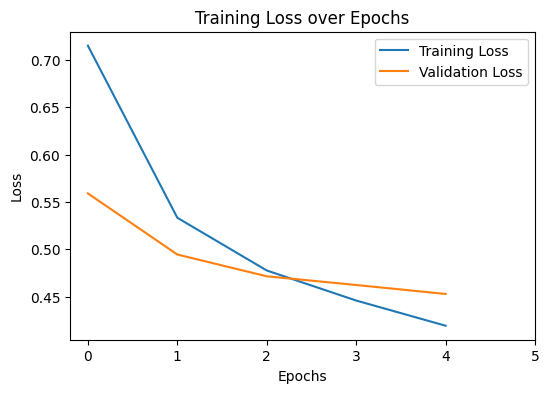

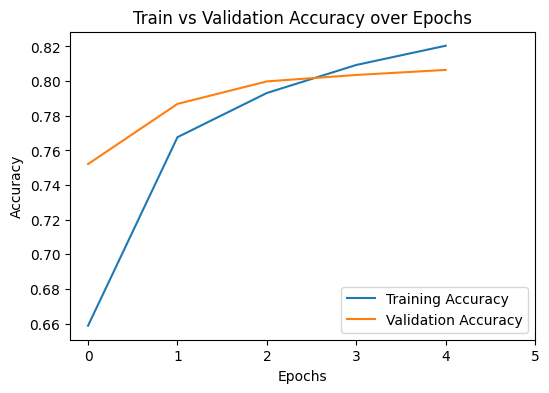

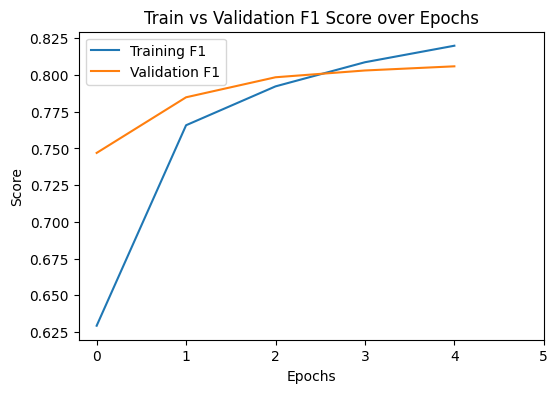

In [152]:
# Plots
import matplotlib.pyplot as plt

# Training vs Validation Loss
plt.figure(figsize=(6,4))
plt.plot(tr_loss, label='Training Loss')
plt.plot(v_loss, label='Validation Loss')
plt.xticks(range(0, 6, 1)) 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Train vs Validation Accuracy
plt.figure(figsize=(6,4))
plt.plot(ac, label='Training Accuracy')
plt.plot(vac, label='Validation Accuracy')
plt.xticks(range(0, 6, 1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy over Epochs')
plt.legend()
plt.show()

# Train vs Validation F1 Score
plt.figure(figsize=(6,4))
plt.plot(f, label='Training F1')
plt.plot(vf, label='Validation F1')
plt.xticks(range(0, 6, 1))
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Train vs Validation F1 Score over Epochs')
plt.legend()
plt.show()


Text only BERT model performance on test set

In [153]:
# collect predictions and labels
all_preds, all_labels = [], []
test_loss, test_acc, test_f1 = evaluate_text_model(text_model, test_text_loader)
print("Perfromance of Text only BERT model on test data:")
print(f"Test loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, F1: {test_f1:.4f}")

Perfromance of Text only BERT model on test data:
Test loss: 0.4535, Accuracy: 0.8062, F1: 0.8053


In [154]:
for key, value in batch.items():
    print(f"{key}: {value.shape if hasattr(value, 'shape') else type(value)}")


input_ids: torch.Size([16, 32])
attention_mask: torch.Size([16, 32])
label: torch.Size([16])


Save BERT model for fusion later

In [155]:
torch.save(text_model.state_dict(), "bert_text_only.pt")

Train Image only ResNet model

In [156]:
def evaluate_image_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    avg_loss = total_loss/len(loader)
    return avg_loss, acc, f1

In [157]:
tr_loss = []
v_loss = []
ac = []
vac = []
f = []
vf = []

def train_image_model(model, train_loader, val_loader, epochs=5, lr=1e-6): # reduced learning rate
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4) # added weight decay

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).detach().cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        avg_loss = total_loss/len(train_loader)
        tr_loss.append(avg_loss)
        ac.append(acc)
        f.append(f1)
        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f}, Acc: {acc:.4f}, F1: {f1:.4f}")

        vloss, vacc, vf1 = evaluate_image_model(model, val_loader)
        v_loss.append(vloss)
        vac.append(vacc)
        vf.append(vf1)
        print(f"Validation Loss: {vloss:.4f}, Accuracy: {vacc:.4f}, F1: {vf1:.4f}")
    return model

In [158]:
image_model = ImageClassifier().to(device)
image_model = train_image_model(image_model, train_image_loader, val_image_loader)

Epoch 1: 100%|██████████| 1886/1886 [1:22:48<00:00,  2.63s/it]


Epoch 1 | Train Loss: 1.0047, Acc: 0.4863, F1: 0.4904
Validation Loss: 0.9311, Accuracy: 0.5369, F1: 0.4968


Epoch 2: 100%|██████████| 1886/1886 [1:21:53<00:00,  2.61s/it]


Epoch 2 | Train Loss: 0.8549, Acc: 0.5632, F1: 0.5179
Validation Loss: 0.8292, Accuracy: 0.5689, F1: 0.5220


Epoch 3: 100%|██████████| 1886/1886 [1:20:07<00:00,  2.55s/it]


Epoch 3 | Train Loss: 0.7977, Acc: 0.5811, F1: 0.5401
Validation Loss: 0.7896, Accuracy: 0.5936, F1: 0.5498


Epoch 4: 100%|██████████| 1886/1886 [1:20:40<00:00,  2.57s/it]


Epoch 4 | Train Loss: 0.7665, Acc: 0.5980, F1: 0.5618
Validation Loss: 0.7653, Accuracy: 0.5946, F1: 0.5518


Epoch 5: 100%|██████████| 1886/1886 [1:20:31<00:00,  2.56s/it]


Epoch 5 | Train Loss: 0.7464, Acc: 0.6114, F1: 0.5801
Validation Loss: 0.7452, Accuracy: 0.6068, F1: 0.5723


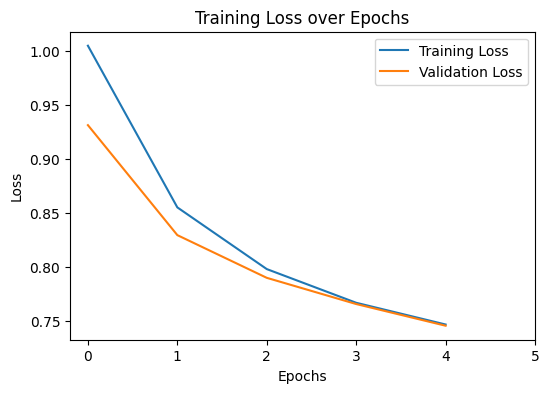

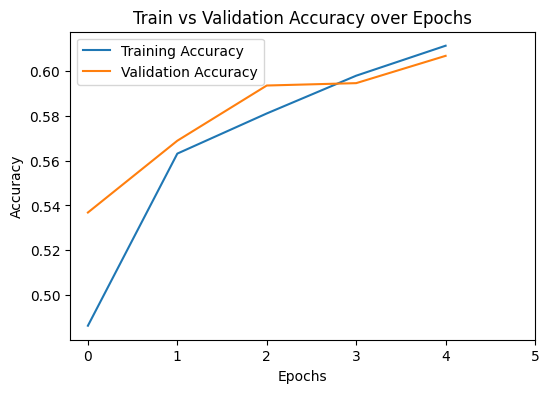

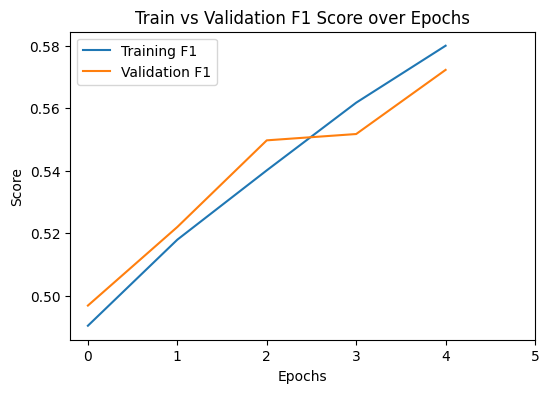

In [159]:
# plot loss, accuracy, f1
# Training vs Validation Loss
plt.figure(figsize=(6,4))
plt.plot(tr_loss, label='Training Loss')
plt.plot(v_loss, label='Validation Loss')
plt.xticks(range(0, 6, 1)) 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Train vs Validation Accuracy
plt.figure(figsize=(6,4))
plt.plot(ac, label='Training Accuracy')
plt.plot(vac, label='Validation Accuracy')
plt.xticks(range(0, 6, 1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy over Epochs')
plt.legend()
plt.show()

# Train vs Validation F1 Score
plt.figure(figsize=(6,4))
plt.plot(f, label='Training F1')
plt.plot(vf, label='Validation F1')
plt.xticks(range(0, 6, 1))
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Train vs Validation F1 Score over Epochs')
plt.legend()
plt.show()

Image only ResNet performance on test data

In [160]:
# collect predictions and labels
all_preds, all_labels = [], []
tloss, tacc, tf1 = evaluate_image_model(image_model, test_image_loader)
print("Perfromance of Image only ResNet model on test data:")
print(f"Test loss: {tloss:.4f}, Accuracy: {tacc:.4f}, F1: {tf1:.4f}")

Perfromance of Image only ResNet model on test data:
Test loss: 0.7433, Accuracy: 0.6182, F1: 0.5851


save image only ResNet model

In [161]:
torch.save(image_model.state_dict(), "resnet_image_only.pt")

Train BERT and ResNet Fusion model

In [162]:
def evaluate_fusion_model(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    avg_loss = total_loss/len(loader)
    return avg_loss, acc, f1

In [163]:
tr_loss = []
v_loss = []
ac = []
vac = []
f = []
vf = []
def train_fusion_model(model, train_loader, val_loader, epochs=5, lr=1e-6): # reduced learning rate
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=1e-4) # added weight decay

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        for batch in tqdm(train_loader, desc=f"Fusion Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = outputs.argmax(dim=1).detach().cpu()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        avg_loss = total_loss/len(train_loader)
        tr_loss.append(avg_loss)
        ac.append(acc)
        f.append(f1)
        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f}, Acc: {acc:.4f}, F1: {f1:.4f}")

        vloss, vacc, vf1 = evaluate_fusion_model(model, val_loader)
        v_loss.append(vloss)
        vac.append(vacc)
        vf.append(vf1)
        print(f"Validation Loss: {vloss:.4f}, Accuracy: {vacc:.4f}, F1: {vf1:.4f}")
        print(f"Current α: {fusion_model.alpha.item():.3f}")
    return model

In [164]:
fusion_model = BertResNetLateFusion(
    text_model_path="bert_text_only.pt",
    image_model_path="resnet_image_only.pt",
    num_classes=3,
    freeze_encoders=True 
)

fusion_model = train_fusion_model(fusion_model, train_loader, val_loader)

Loaded pretrained BERT weights
Loaded pretrained ResNet weights


Fusion Epoch 1: 100%|██████████| 1886/1886 [2:43:34<00:00,  5.20s/it]  


Epoch 1 | Train Loss: 0.6477, Acc: 0.7583, F1: 0.7459
Validation Loss: 0.5086, Accuracy: 0.7818, F1: 0.7685
Current α: 0.501


Fusion Epoch 2: 100%|██████████| 1886/1886 [3:05:10<00:00,  5.89s/it]  


Epoch 2 | Train Loss: 0.4394, Acc: 0.8237, F1: 0.8212
Validation Loss: 0.4668, Accuracy: 0.8059, F1: 0.8061
Current α: 0.502


Fusion Epoch 3: 100%|██████████| 1886/1886 [8:13:16<00:00, 15.69s/it]       


Epoch 3 | Train Loss: 0.3877, Acc: 0.8484, F1: 0.8482
Validation Loss: 0.4678, Accuracy: 0.8112, F1: 0.8107
Current α: 0.503


Fusion Epoch 4: 100%|██████████| 1886/1886 [2:21:42<00:00,  4.51s/it]  


Epoch 4 | Train Loss: 0.3633, Acc: 0.8575, F1: 0.8573
Validation Loss: 0.4595, Accuracy: 0.8142, F1: 0.8144
Current α: 0.503


Fusion Epoch 5: 100%|██████████| 1886/1886 [2:28:56<00:00,  4.74s/it]  


Epoch 5 | Train Loss: 0.3416, Acc: 0.8673, F1: 0.8672
Validation Loss: 0.4659, Accuracy: 0.8171, F1: 0.8166
Current α: 0.503


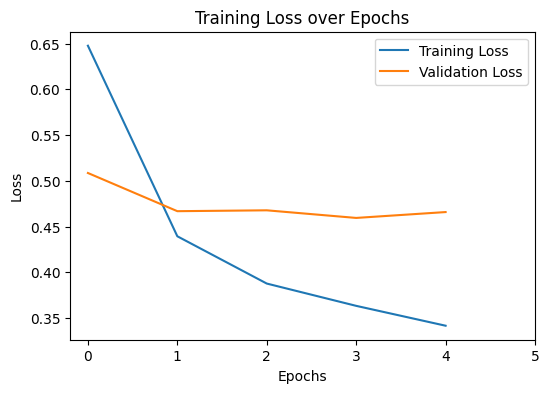

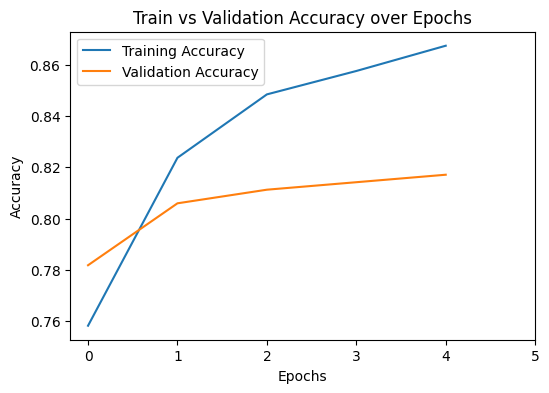

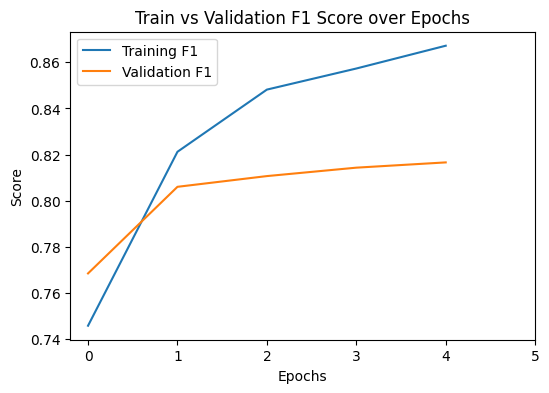

In [165]:
# plot loss, accuracy, f1
# Training vs Validation Loss
plt.figure(figsize=(6,4))
plt.plot(tr_loss, label='Training Loss')
plt.plot(v_loss, label='Validation Loss')
plt.xticks(range(0, 6, 1)) 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Train vs Validation Accuracy
plt.figure(figsize=(6,4))
plt.plot(ac, label='Training Accuracy')
plt.plot(vac, label='Validation Accuracy')
plt.xticks(range(0, 6, 1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy over Epochs')
plt.legend()
plt.show()

# Train vs Validation F1 Score
plt.figure(figsize=(6,4))
plt.plot(f, label='Training F1')
plt.plot(vf, label='Validation F1')
plt.xticks(range(0, 6, 1))
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Train vs Validation F1 Score over Epochs')
plt.legend()
plt.show()

BERT-ResNet fusion model perfromance on test data

In [166]:
# collect predictions and labels
all_preds, all_labels = [], []
tloss, tacc, tf1 = evaluate_fusion_model(fusion_model, test_loader)
print("Perfromance of Image and Text BERT-ResNet Fusion model on test data:")
print(f"Test loss: {tloss:.4f}, Accuracy: {tacc:.4f}, F1: {tf1:.4f}")

Perfromance of Image and Text BERT-ResNet Fusion model on test data:
Test loss: 0.4692, Accuracy: 0.8208, F1: 0.8199


In [169]:
import seaborn as sns

In [170]:
# define label names
label_names = ['True', 'Misleading', 'Fake']

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# collect predictions and labels
all_preds, all_labels = [], []
loop = tqdm(test_loader, desc='Testing')
with torch.no_grad():
    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        logits = model(batch["input_ids"], batch["attention_mask"], batch["image"])
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["label"].cpu().numpy())
# print classification report
report = classification_report(all_l, all_p, target_names=label_names, digits=4)
print('\n=== Classification Report (Full Fine-tuning) ===\n')
print(report)

Testing: 100%|██████████| 236/236 [09:33<00:00,  2.43s/it]


=== Classification Report (Full Fine-tuning) ===

              precision    recall  f1-score   support

        True     0.7995    0.8550    0.8263     12486
  Misleading     0.8716    0.7534    0.8082       811
        Fake     0.7752    0.7123    0.7424      9335

    accuracy                         0.7925     22632
   macro avg     0.8154    0.7736    0.7923     22632
weighted avg     0.7920    0.7925    0.7911     22632



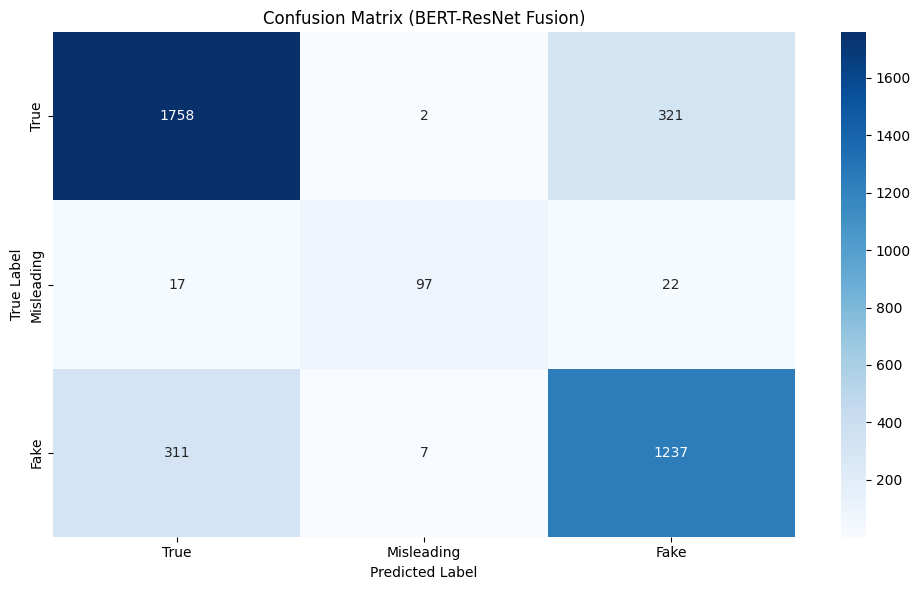

In [171]:
# plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (BERT-ResNet Fusion)')
plt.tight_layout()
plt.show()

In [173]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

In [175]:
import numpy as np

In [176]:
# binarize labels for ROC and precision-recall curves
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2])
n_classes = y_true_bin.shape[1]

# get prediction probabilities
all_probs = []
loop = tqdm(test_loader, desc='Collecting probabilities')
with torch.no_grad():
    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        logits = model(batch["input_ids"], batch["attention_mask"], batch["image"])
        probs = torch.softmax(logits, dim=-1)
        all_probs.extend(probs.cpu().numpy())

all_probs = np.array(all_probs)

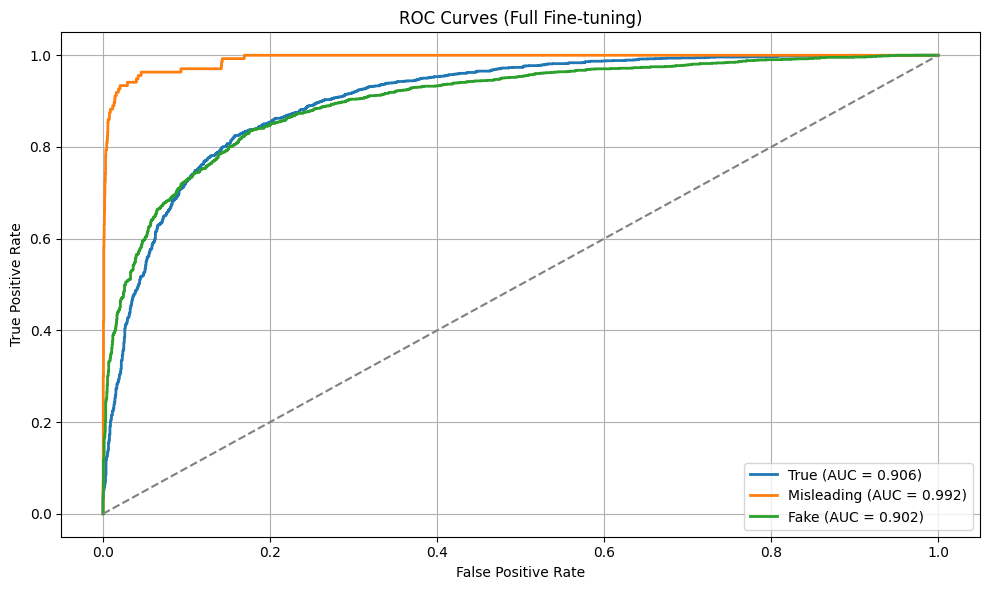

In [177]:
# plot ROC curves
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
for i, name in enumerate(label_names):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{name} (AUC = {roc_auc[i]:.3f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Full Fine-tuning)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

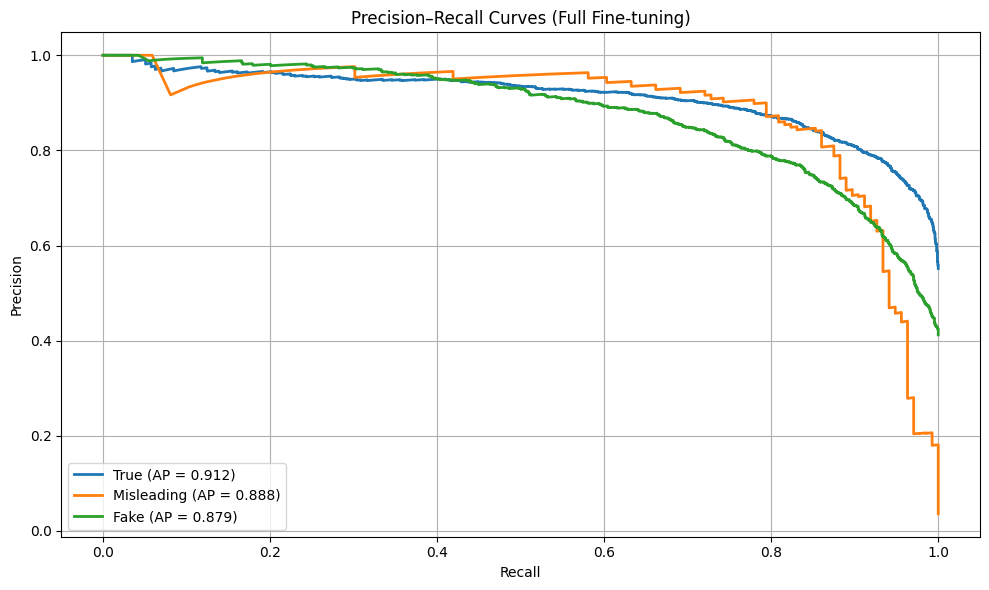

In [178]:
# plot precision-recall curves
precision, recall, avg_precision = {}, {}, {}
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], all_probs[:, i])
    avg_precision[i] = average_precision_score(y_true_bin[:, i], all_probs[:, i])

plt.figure(figsize=(10, 6))
for i, name in enumerate(label_names):
    plt.plot(recall[i], precision[i], lw=2, label=f"{name} (AP = {avg_precision[i]:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (Full Fine-tuning)")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

Save BERT-ResNet fusion model

In [ ]:
torch.save(fusion_model.state_dict(), "bert_resnet_fusion.pt")